In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 90.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.5 MB/s eta 0:00:00


In [5]:
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import torch.nn.functional as F
import csv
import re 

In [6]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [7]:
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device("cpu")
print(f"Using {device_name}")

Using cuda


In [8]:
data_file = "/content/gdrive/My Drive/raw_stories.txt" 

In [14]:
STORIES = {}
POEM_AUTHORS = ['EDWARD LEAR', 'ISAAC WATTS', 'JANE TAYLOR', 'PHOEBE CARY', 'ANN TAYLOR', 'ANONYMOUS', 'CHARLES KINGSLEY', 'CHARLES MACKAY', 'CLEMENT CLARKE MOORE', 'DAVID EVERETT', 'ELIZA LEE FOLLEN', 'FELICIA DOROTHEA HEMANS', 'FELICIA DOROTHEA HEMANS', 'FELICIA DOROTHEA HEMANS', 'FRANCIS C. WOODWORTH', 'FROM M. DE LAMOTTE', 'GEORGE MACDONALD', 'HANNAH FLAGG GOULD', 'HENRY WADSWORTH LONGFELLOW', 'JAMES HOGG', 'JAMES MERRICK',
                'JAMES WHITCOMB RILEY', 'JANE TAYLOR', 'JEMIMA LUKE', 'LEWIS CARROLL', 'LITTLE B. (TAYLOR?)', 'LYDIA MARIA CHILD', 'MARY HOWITT', 'MARY HOWITT', 'MARY HOWITT', 'OLD CAROL', 'REGINALD HEBER', 'RICHARD MONCKTON MILNES (LORD HOUGHTON)', 'ROBERT BURNS', 'ROBERT LOUIS STEVENSON', 'ROBERT SOUTHEY', 'SABINE BARING-GOULD', 'THOMAS HOOD', 'WILLIAM BRIGHTY RANDS', 'WILLIAM HOWITT', 'WILLIAM ROBERT SPENCER', 'WILLIAM SHAKESPEARE', 'WILLIAM WORDSWORTH']
STORY_TYPES = ['SCANDINAVIAN STORIES', 'GERMAN STORIES', 'FRENCH STORIES', 'ENGLISH STORIES','CELTIC STORIES', 'ITALIAN STORIES', 'JAPANESE STORIES', 'EAST INDIAN STORIES', 'AMERICAN INDIAN STORIES', 'ARABIAN STORIES', 'CHINESE STORIES', 'RUSSIAN STORIES', 'TALES FOR TINY TOTS', 'FANCIFUL STORIES', 'OUR CHILDREN', 'PINOCCHIO\'S ADVENTURES IN WONDERLAND[1]']


def clean_data():
    with open(data_file, "r") as f:
        lines = f.readlines()
        first_line = lines[0].strip(" \n")
        curr_title = re.sub('[\t]+', '', first_line).upper()
        for i in range(1, len(lines) - 1):
            line = lines[i].strip(" \n")
            line = re.sub('[\t]+', '', line)  # to remove tabs
            line = re.sub("        ", '', line)
            if len(line) == 0 or (line in POEM_AUTHORS) or (line in STORY_TYPES) or ("ADAPTED BY" in line):
                continue

            elif (line in ["CINDERELLA", "BLUE BEARD", "SUPPOSE!", "PRETTY COW", "THE OWL AND THE PUSSY-CAT"]):
                curr_title = line
                STORIES[curr_title] = []

            if (line == '\n' or len(line) < 3) and len(lines[i+1]) < 50:
                upcoming_title = lines[i+1].strip(" \n")
                curr_title = re.sub('[\t]+', '', upcoming_title).upper()

            elif (line[0].isnumeric()):
                curr_title = line.upper()
                STORIES[curr_title] = []

            elif (line.isupper() and ("ADAPTED BY" in lines[i+1] or "BY " in lines[i+1])):
                curr_title = line
                STORIES[curr_title] = []

            elif (line.isupper() and " STORY" in lines[i+1]):
                first_sentence = lines[i+1].split()
                if "--" in curr_title:
                    # replace with next chapter
                    curr_title = curr_title.split(
                        " --", 1)[0] + " --" + ' '.join(first_sentence[0:2])
                else:
                    curr_title = line + " --" + ' '.join(first_sentence[0:2])

                STORIES[curr_title] = [' '.join(first_sentence[2:])]

            elif (" STORY" in line or " Story." in line) and not ("OF" in line and not (" STORY" in lines[i+1])):
                first_sentence = line.split()
                if "--" in curr_title:
                    # replace with next chapter
                    curr_title = curr_title.split(
                        " --", 1)[0] + " --" + ' '.join(first_sentence[0:2])
                else:
                    curr_title = curr_title + " --" + \
                        ' '.join(first_sentence[0:2])

                begin_story = [' '.join(first_sentence[2:])]
                if len(begin_story) <= 1:
                    STORIES[curr_title] = []
                else:
                    STORIES[curr_title] = [' '.join(first_sentence[2:])]

            elif (line.isupper()) and not (str(lines[i+1].split()[0:2]).isupper() or ("THE END" in line) or ("\"" in line) or ("“" in line) or ("\'" in line) or ("{" in line) or (line in "TRESPASSERS WILL BE PROSECUTED") or (line in "FAMOUS DONKEY THE STAR OF THE DANCE") or ("ADAPTED BY" in line) or (line in "* A.D. 1482-1513")):
                if (len(line) >= 11 and len(line) < 50):
                    curr_title = line.upper()
                    STORIES[curr_title] = []

                elif (len(line) < 11 and len(line) < 50) or (line in "CHAPTER"):
                    if "--" in curr_title:
                        # replace with next chapter
                        curr_title = curr_title.split(
                            " --", 1)[0] + " --" + line
                    if not (line in curr_title):
                        curr_title = curr_title + " --" + line
                    STORIES[curr_title] = []

            elif (curr_title in STORIES) and (line.upper() != curr_title):
                STORIES[curr_title].append(line)
            else:
                STORIES[curr_title] = []

    # To finalize the cleaning: removes extra titles that never got fed in
    STORIES_COPY = STORIES.copy()
    for story in STORIES_COPY:
        if STORIES[story] == []:
            STORIES.pop(story)

    # Making each story in the dictionary a full string so that it matches the tutorial's format
    for title in STORIES:
        STORIES[title] = ' '.join(STORIES[title])

clean_data()

In [15]:
valid_stories = []
for key, value in STORIES.items():
  if len(value) >= 600:  # stories that are too short aren't useful for us  
    valid_stories.append(value) 

STORIES = {}

In [16]:
total_data = len(valid_stories) 

In [17]:
import random 

training_set_size = int(total_data * 0.7) 
validation_set_size = int(total_data * 0.1)
testing_set_size = int(total_data * 0.2)

random.seed(46)   # ensuring we can replicate the results 

random.shuffle(valid_stories)

training_set = valid_stories[:training_set_size]
validation_set = valid_stories[training_set_size:training_set_size + validation_set_size]
testing_set = valid_stories[training_set_size + validation_set_size:]

In [ ]:
# Dataset comes from torch.utils.data
class Stories(Dataset):
    def __init__(self, control_code, truncate=False, gpt2_type="gpt2", max_length=1024):
        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        self.stories = []

        for story in control_code:
          self.stories.append(torch.tensor(
                self.tokenizer.encode(f"<|startoftext|>{story}<|endoftext|>")[:max_length]
            ))
        if truncate:
            self.stories = self.stories[:20000]
        self.stories_count = len(self.stories)
    def __len__(self):
        return self.stories_count

    def __getitem__(self, item):
        return self.stories[item]

In [ ]:
dataset = Stories(training_set, truncate=True, gpt2_type="gpt2")      
val_dataset = Stories(validation_set, truncate=True, gpt2_type="gpt2")

Token indices sequence length is longer than the specified maximum sequence length for this model (1280 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9491 > 1024). Running this sequence through the model will result in indexing errors


In [20]:
#Get the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

#Accumulated batch size (since GPT2 is so big)
def pack_tensor(new_tensor, packed_tensor, max_seq_len):
    if packed_tensor is None:
        return new_tensor, True, None
    if new_tensor.size()[1] + packed_tensor.size()[1] > max_seq_len:
        return packed_tensor, False, new_tensor
    else:
        packed_tensor = torch.cat([new_tensor, packed_tensor[:, 1:]], dim=1)
        return packed_tensor, True, None

In [ ]:
def calculate_val_loss(validation_set, model):
    model.eval()
    device=device_name
    with torch.no_grad():
      val_dataloader = DataLoader(validation_set, batch_size=1)
      loss = 0
      
      input_tensor = None
      for idx, entry in tqdm(enumerate(val_dataloader)):
          entry = entry.to(device)
          (input_tensor, carry_on, remainder) = pack_tensor(entry, input_tensor, 768)
          if carry_on and idx != len(val_dataloader) - 1:
              continue

          input_tensor = input_tensor.to(device)
          outputs = model(input_tensor, labels=input_tensor)
          
          loss = outputs[0]
    return loss

checkpoint_path =  "/content/gdrive/My Drive/CSC413/bestModel.pt"
checkpoint2_latest =  "/content/gdrive/My Drive/CSC413/latestModel.pt"

In [ ]:
def train(
    dataset, model, tokenizer,
    batch_size=4, epochs=2, lr=2e-5,
    max_seq_len=400, warmup_steps=200, test_mode=False, validation_set=None
):
    acc_steps = 100
    device=device_name
    model = model.cuda()

    optimizer = AdamW(model.parameters(), lr=lr)
    # scheduler = get_linear_schedule_with_warmup(
    #     optimizer, num_warmup_steps=warmup_steps, num_training_steps=-1
    # )

    train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    loss=0
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    accumulating_batch_count = 0
    input_tensor = None

    for epoch in range(epochs):
        if validation_set:  # also recording initial validation loss for progress 
            print("about to start validating")
            val_loss = calculate_val_loss(validation_set, model)
            val_losses.append(val_loss.item())

            if val_loss < best_val_loss:
              print("saving new model")
              best_val_loss = val_loss 
              torch.save(model.state_dict(), checkpoint_path)
            
            # also save latest model, we might like some overfitting
            torch.save(model.state_dict(), checkpoint2_latest)
        
        print(f"Training epoch {epoch}")


        running_training_loss = 0 
        data_points = 0 
        model.train()
        for idx, entry in tqdm(enumerate(train_dataloader)):
            (input_tensor, carry_on, remainder) = pack_tensor(entry, input_tensor, 768)

            if carry_on and idx != len(train_dataloader) - 1:
                continue

            input_tensor = input_tensor.to(device)
            outputs = model(input_tensor, labels=input_tensor)
            loss = outputs[0]
            data_points += 1 
            running_training_loss += loss.item()
            loss.backward()


            if (accumulating_batch_count % batch_size) == 0:
                optimizer.step()
                # scheduler.step()
                optimizer.zero_grad()
                model.zero_grad()

            accumulating_batch_count += 1
            input_tensor = None
        
        train_losses.append(running_training_loss / data_points)
        
    return model, ([i for i in range(epochs)], train_losses, val_losses)

In [ ]:
model, plot_info = train(dataset, model, tokenizer, epochs=13, validation_set=val_dataset)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


about to start validating


144it [00:16,  8.56it/s]


saving new model
Training epoch 0


1013it [02:22,  7.09it/s]


about to start validating


144it [00:15,  9.51it/s]


saving new model
Training epoch 1


1013it [02:30,  6.75it/s]


about to start validating


144it [00:15,  9.21it/s]


saving new model
Training epoch 2


1013it [02:28,  6.80it/s]


about to start validating


144it [00:15,  9.28it/s]


saving new model
Training epoch 3


1013it [02:31,  6.70it/s]


about to start validating


144it [00:15,  9.19it/s]


saving new model
Training epoch 4


1013it [02:29,  6.77it/s]


about to start validating


144it [00:15,  9.17it/s]


saving new model
Training epoch 5


1013it [02:31,  6.71it/s]


about to start validating


144it [00:15,  9.32it/s]


saving new model
Training epoch 6


1013it [02:31,  6.70it/s]


about to start validating


144it [00:15,  9.29it/s]


Training epoch 7


1013it [02:29,  6.80it/s]


about to start validating


144it [00:15,  9.29it/s]


Training epoch 8


1013it [02:29,  6.78it/s]


about to start validating


144it [00:15,  9.26it/s]


Training epoch 9


1013it [02:30,  6.75it/s]


about to start validating


144it [00:15,  9.19it/s]


Training epoch 10


1013it [02:30,  6.75it/s]


about to start validating


144it [00:15,  9.17it/s]


Training epoch 11


1013it [02:27,  6.85it/s]


about to start validating


144it [00:15,  9.19it/s]


Training epoch 12


1013it [02:30,  6.73it/s]


Training:  [3.335051125157141, 3.2348452778033185, 3.1811376230650215, 3.163368068130843, 3.1348647621888963, 3.112296778046918, 3.0772500750091343, 3.0656872115599705, 3.0462578372955322, 3.034501554131508, 2.987476157952115, 2.962560038008387, 2.9489242871760375]
Validation: [3.249417781829834, 3.1083149909973145, 3.101541519165039, 3.0856988430023193, 3.0813491344451904, 3.0770692825317383, 3.0653364658355713, 3.0731968879699707, 3.07873272895813, 3.0858922004699707, 3.071104049682617, 3.0812222957611084, 3.069622755050659]


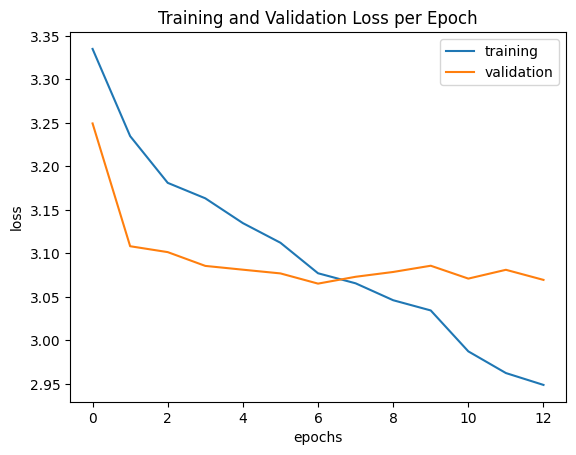

In [ ]:
def plot_training_curve(epochs, train_losses, valid_losses):

    print("Training: ", train_losses)
    print("Validation:", valid_losses)
    # Training plot
    plt.title("Training and Validation Loss per Epoch")
    plt.plot(epochs, train_losses, label="training")
    plt.plot(epochs, valid_losses, label="validation")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.show()
  
plot_training_curve(*plot_info)

# Testing the model

In [10]:
# Load the best checkpoint
checkpoint_path =  "/content/gdrive/My Drive/CSC413/bestModel.pt"

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model2 = GPT2LMHeadModel.from_pretrained('gpt2', force_download=True)

saved_state_dict = torch.load(checkpoint_path)

model2.load_state_dict(saved_state_dict)

<All keys matched successfully>

In [11]:
def complete_prompt(prompt, model, min_length=50, max_length=200, top_p=0.8, temperature=0.9):
    inputs = tokenizer.encode(prompt, return_tensors="pt")
    outputs = model.generate(
        inputs,
        do_sample=True,
        min_length=min_length,
        max_length=max_length,
        top_p=top_p,
        temperature=temperature,
        pad_token_id=tokenizer.eos_token_id
    )
    completed_story = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return completed_story

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np

smoothie = SmoothingFunction().method4   # recommended in warning 

scores = []

for story in testing_set:
    story_words = story.split(' ')
    story_words = story_words[:100]   # Evaluate initial part of story  
    
    words_for_completion = 30 
    prompt = story_words[:-words_for_completion]
    start = ' '.join(prompt)
    completion = story_words[-words_for_completion:]
    end = ' '.join(completion)

    candidate = complete_prompt(start, model2, min_length=100, max_length=150)
    canadidate_list = candidate.split(' ')
    print("Candidate is: ", canadidate_list)
    print("story is: ", story_words)
    
    score = sentence_bleu(story_words, canadidate_list, smoothing_function=smoothie)
    print("Score is: ", score)
    scores.append(score)

In [ ]:
print("New score is: ", np.mean(scores))

New score is:  0.0032831385228806603


## Different Metric: ROGUE


In [12]:
# Code taken from: https://towardsdatascience.com/how-to-evaluate-text-generation-models-metrics-for-automatic-evaluation-of-nlp-models-e1c251b04ec1


import itertools

#supporting function
def _split_into_words(sentences):
  """Splits multiple sentences into words and flattens the result"""
  return list(itertools.chain(*[_.split(" ") for _ in sentences]))

#supporting function
def _get_word_ngrams(n, sentences):
  """Calculates word n-grams for multiple sentences.
  """
  assert len(sentences) > 0
  assert n > 0

  words = _split_into_words(sentences)
  return _get_ngrams(n, words)

#supporting function
def _get_ngrams(n, text):
  """Calcualtes n-grams.
  Args:
    n: which n-grams to calculate
    text: An array of tokens
  Returns:
    A set of n-grams
  """
  ngram_set = set()
  text_length = len(text)
  max_index_ngram_start = text_length - n
  for i in range(max_index_ngram_start + 1):
    ngram_set.add(tuple(text[i:i + n]))
  return ngram_set

def rouge_n(reference_sentences, evaluated_sentences, n=2):
  """
  Computes ROUGE-N of two text collections of sentences.
  Source: http://research.microsoft.com/en-us/um/people/cyl/download/
  papers/rouge-working-note-v1.3.1.pdf
  Args:
    evaluated_sentences: The sentences that have been picked by the summarizer
    reference_sentences: The sentences from the referene set
    n: Size of ngram.  Defaults to 2.
  Returns:
    recall rouge score(float)
  Raises:
    ValueError: raises exception if a param has len <= 0
  """
  if len(evaluated_sentences) <= 0 or len(reference_sentences) <= 0:
    raise ValueError("Collections must contain at least 1 sentence.")

  evaluated_ngrams = _get_word_ngrams(n, evaluated_sentences)
  reference_ngrams = _get_word_ngrams(n, reference_sentences)
  reference_count = len(reference_ngrams)
  evaluated_count = len(evaluated_ngrams)

  # Gets the overlapping ngrams between evaluated and reference
  overlapping_ngrams = evaluated_ngrams.intersection(reference_ngrams)
  overlapping_count = len(overlapping_ngrams)

  # Handle edge case. This isn't mathematically correct, but it's good enough
  if evaluated_count == 0:
    precision = 0.0
  else:
    precision = overlapping_count / evaluated_count

  if reference_count == 0:
    recall = 0.0
  else:
    recall = overlapping_count / reference_count

  f1_score = 2.0 * ((precision * recall) / (precision + recall + 1e-8))

  #just returning recall count in rouge, useful for our purpose
  return recall

In [ ]:
scores = []
for story in testing_set:
    story_words = story.split(' ')
    story_words = story_words[:100]   # Evaluate initial part of story  
    
    words_for_completion = 30 
    prompt = story_words[:-words_for_completion]
    start = ' '.join(prompt)
    completion = story_words[-words_for_completion:]
    end = ' '.join(completion)

    candidate = complete_prompt(start, model2, min_length=100, max_length=150)
    canadidate_list = candidate.split(' ')
    print("Candidate is: ", canadidate_list)
    print("story is: ", story_words)
    
    score = rouge_n(story_words, canadidate_list)
    print("Score is: ", score)
    scores.append(score)

In [23]:
print("Score is: ", np.mean(scores))

Score is:  0.7100049292719351


In [ ]:
print(complete_prompt("Prince Michael was sick in his bed.", model2))

Prince Michael was sick in his bed. He was so ill he was unable to walk, and was unable to work, and could not even go to his wife. The doctor who treated him found that his head was very swollen and very sore. He had been lying on the floor, and was so ill that he could not move his legs. He was so thirsty that he was almost hungry, and was so thirsty that he could not get water to his mouth. He was so hungry that he could not breathe, and was so hungry that he could not get his head above his head. He had a bad fever and was so bad that he could not get out of bed. He had a bad headache, and was so bad that he could not go to sleep. He was so bad that he could not sleep well, and was so bad that he could not sleep well with his hands on his knees. He was so bad that he could not sleep at all with his feet in his lap.


In [ ]:
print(complete_prompt("<|startoftext|>The three bears went home and found ", model2, max_length=500))

<|startoftext|>The three bears went home and found     a good supper,        and a little                                     And                              The bear's mother cried                                        The child was happy AUDIO (no), and said                                          The bear's mother said                                        The child was happy   AUDIO (no), and said                                           The bear's mother said                                          The child was happy   AUDIO (no), and said                                         The child was happy   AUDIO (no), and said                                                 The child was happy   AUDIO (no), and said                                 


In [ ]:
print(complete_prompt("It was a dark day in Canada. Rain was failing from the sky. Little Jonny found", model2, max_length=200))

It was a dark day in Canada. Rain was failing from the sky. Little Jonny found himself in a dark corner of the house, surrounded by the houses and houses of others. His wife, Hannah, had left him, and the three children, who were very young, had grown up. He had never seen them before. Hannah had come back from work one day to the house and begged him to take her with him, so that they could go back to their father and mother. The three children were all in their thirties, and had been all in a hurry to get out of school. Hannah had been working all day, and she had never been tired of going home and going to work. She had never been hungry or thirsty, and had never been afraid to go outside. It had been so cold, and the house was damp and damp, and the snow was falling, and the children had not slept at all. Hannah had no money, and the only thing she
